---
title: "Data exploration: Delta Sv distribution, by scattering layer"
subtitle: "A simple example with horizontal and well defined layers"
author: "Gaspard Ringuenet"
---

We are interested in the partioning of the ESUs' distribution in the $\Delta S_v$ space when grouping by fine-scale sound scattering layers (SSL; could be even called FSSL to distinguish from the objects usually refered to with the term SSL). Our final goal is to achieve unsupervised multifrequency brod ecosystem acoustic target classification at the ESU level. In other word, we want to produce a pixel-wise segmentation of the echogram, representing the distribution of various acoustic communities.

Our hypothesis is $S_v$ structures (FSSLs) provide interesting starting points to identify groups of ESUs representing similar backscattering organisms communities. 

Since extracting the FSSLs from echointegrated acoustic data is not a straightforward task, we would like to assess the relevance of this task for our goal using a *simplified echogram*, in which identifying FSSLs is easy.

To do so, we chose to use a very short echogram part (~30 min, 285 ESDUs) from a clean sequence of the AMAZOMIX survey (LEG 1).

![Screenshot of the selected echogram part in Matecho.](matecho-screenshot.png)

Let's import the netCDF file for the survey and select the part we're interested in.

In [1]:
# Imports
import os
from PIL import Image

# Local imports
from src.exploration.io import load_survey_ds, print_file_infos
from src.exploration.visualization import plot_survey_map, plot_sv_channels_faceted, plot_3d_scatter, plot_hexbin_2d, plot_hist
from src.exploration.processing import ds_to_sv, filter_depth, get_ch_list, compute_differences, flatten_valid, sample_safe

# Hyperparameters
EI = "amazomix_3pings1m"        # which survey to use as input (see src.exploration.data_config.py)
SV_THRESHOLD = -120             # threshold for min Sv (accross channels), in dB. ESUs with one channel below threshold are removed from analyses
FORCE_PLOT = True

In [2]:
# Import whole survey file
ds = load_survey_ds(survey=EI)

In [3]:
# Import as xarray.Dataset and slice time
frame = 50
start_index = 348984            # time index as displayed in Matecho
end_index = start_index + frame   # added frame length

ds_short = ds.isel(time=slice(start_index, end_index))
print_file_infos(ds_short)

* Title:	Acoustic along the BRAzilian COaSt
* N legs:	1
* Dates (leg1):	09 Sep 2021, 12:20 - 09 Sep 2021, 12:25 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(50, 792, 4) - (time, depth, channel)
* N pixels:	39600


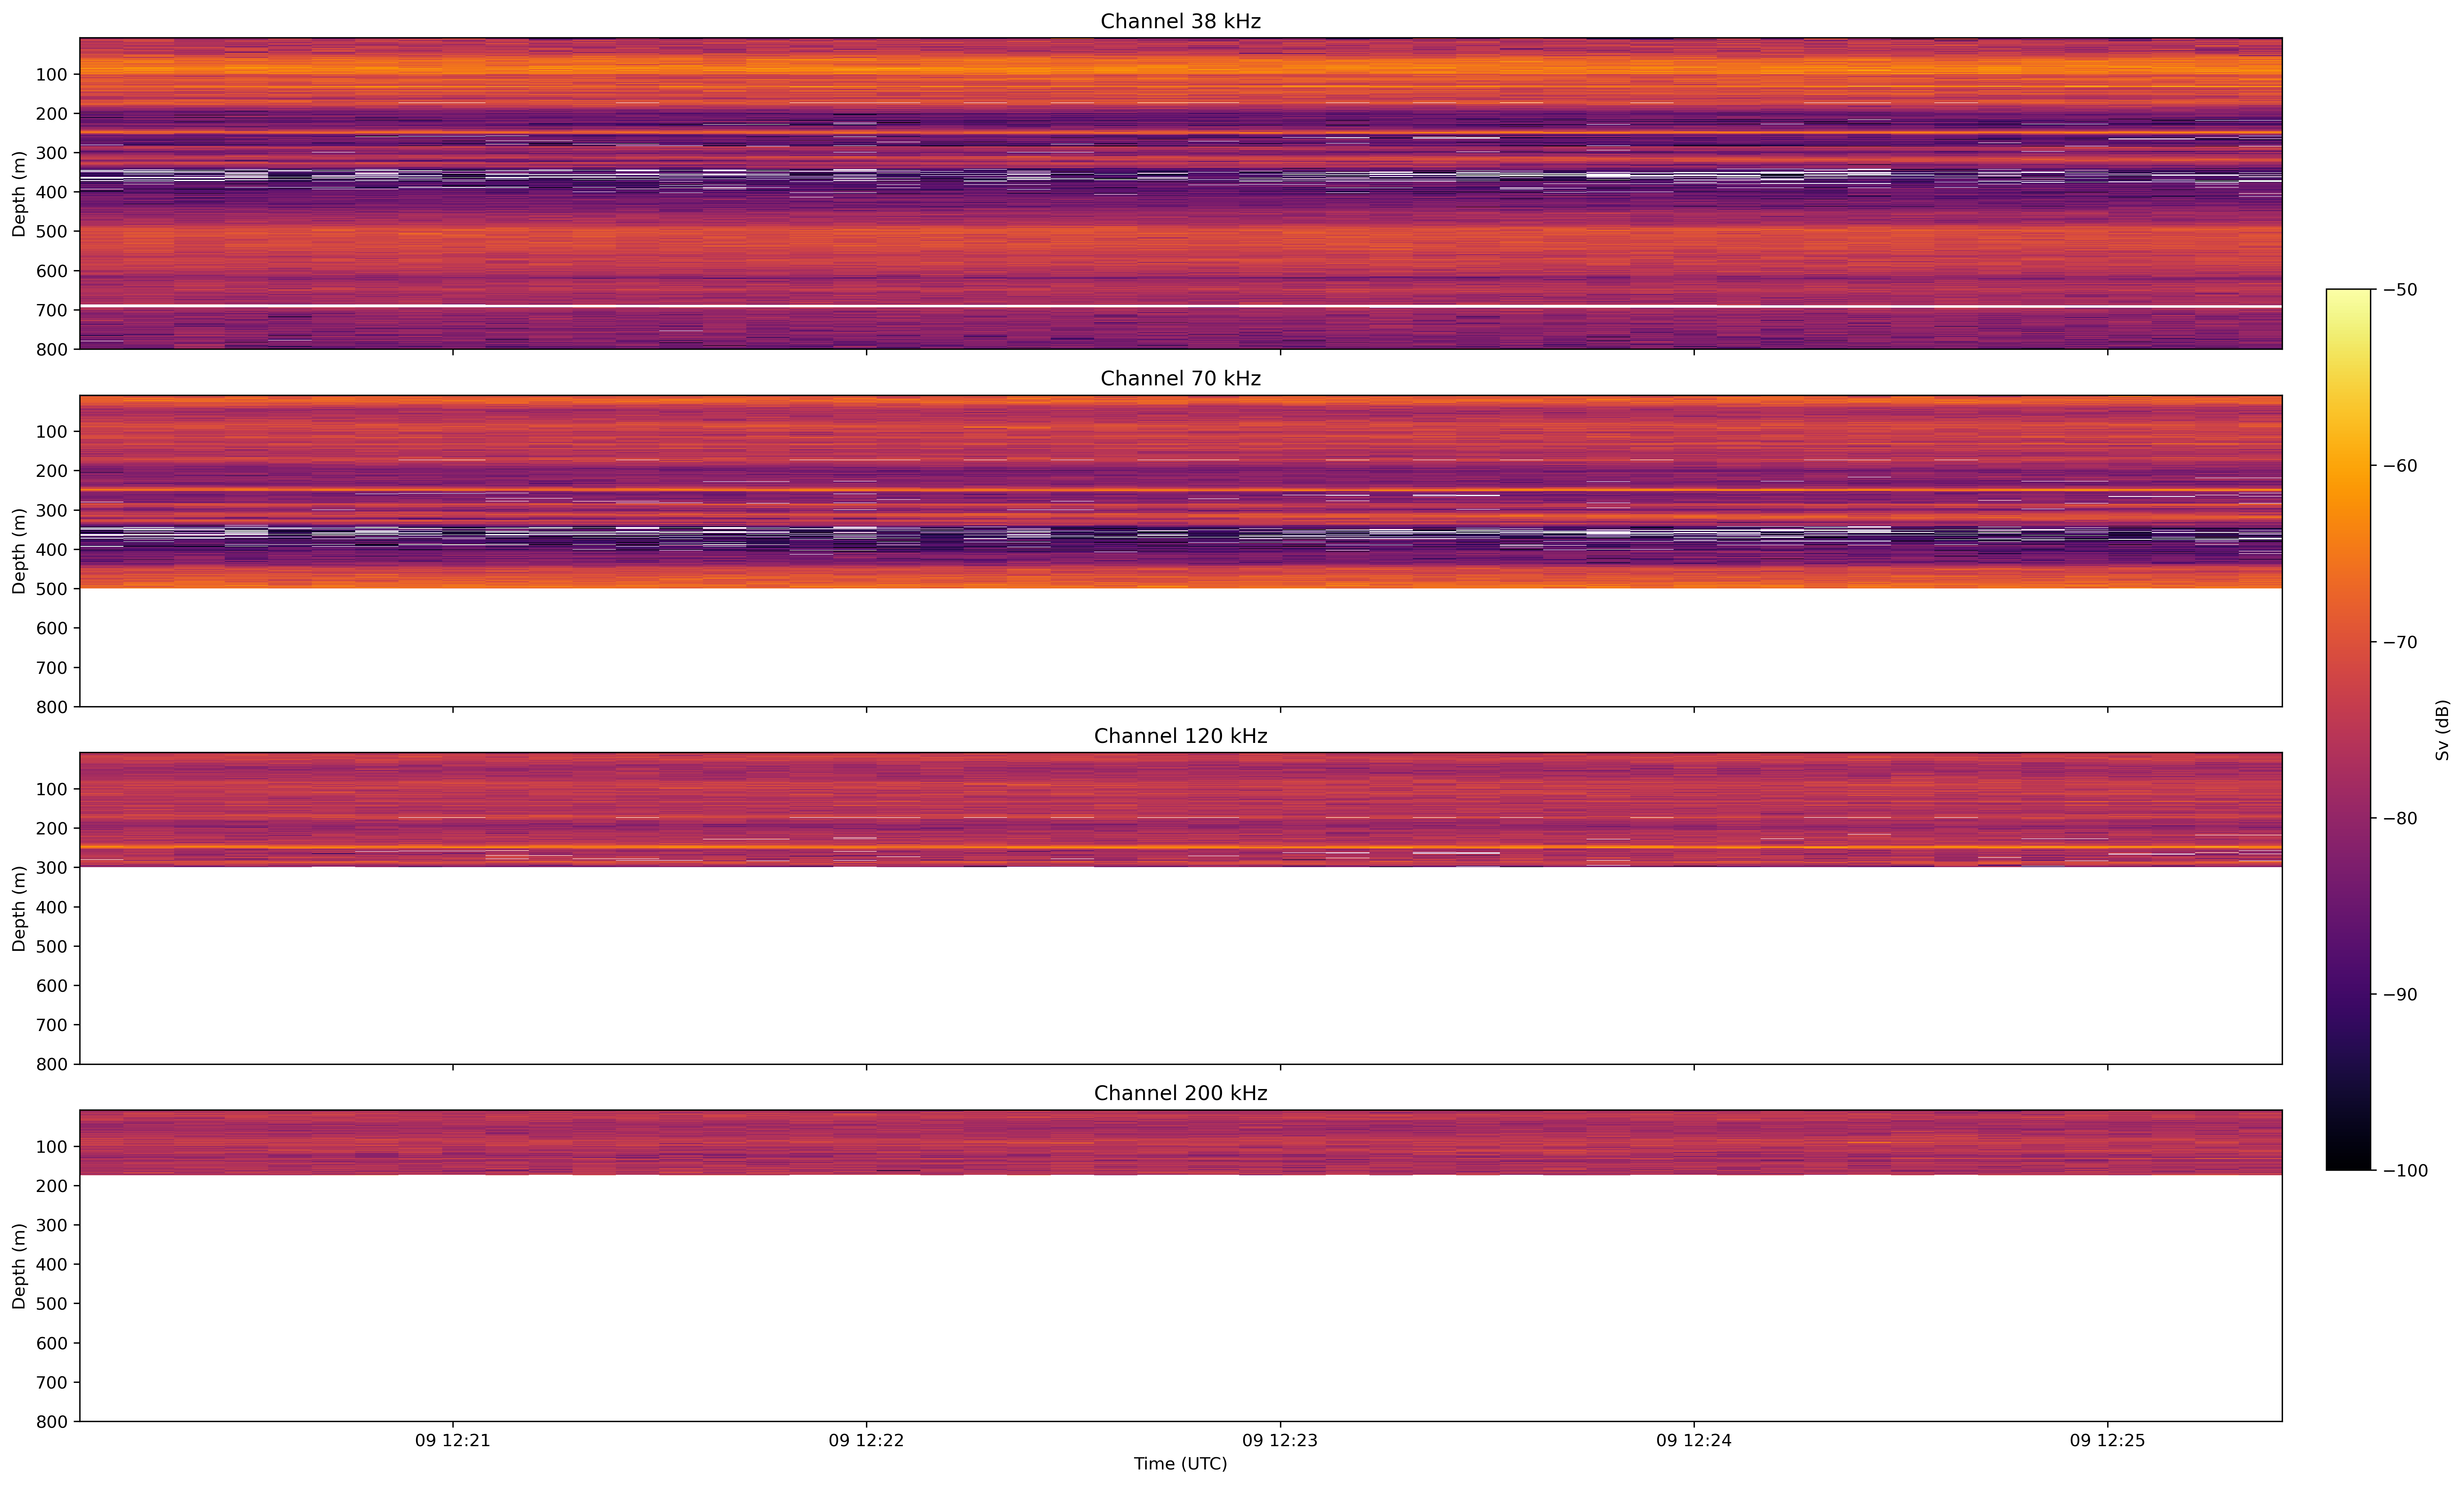

In [4]:
# Extract the `Sv` variable as `xarray.DataArray` and apply a threshold
sv = ds_to_sv(ds_short, sv_threshold=SV_THRESHOLD)

# Visualize the 4 channels
outfile=f"output/figures/{EI}_{frame}ESDUs_4Cfacet.png"

if not os.path.isfile(outfile) or FORCE_PLOT:
    plot_sv_channels_faceted(sv, 
                             outfile,
                             vmin=-100,
                             vmax=-50)
    
img = Image.open(outfile)
img

/Users/gaspardringuenet/Projects/acoustic-communities/env/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


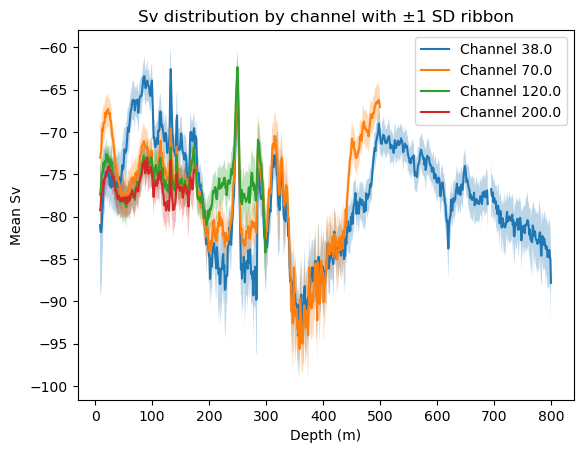

In [5]:
import matplotlib.pyplot as plt

# Compute mean and std of Sv across time
mean_sv = sv.mean(dim="time", skipna=True)
std_sv = sv.std(dim="time", skipna=True)

# Plot each channel with ribbon
fig, ax = plt.subplots()

for channel in mean_sv.channel:
    depth = mean_sv["depth"]
    mean_vals = mean_sv.sel(channel=channel)
    std_vals = std_sv.sel(channel=channel)

    ax.plot(depth, mean_vals, label=f"Channel {channel.values}")
    ax.fill_between(
        depth,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.3
    )

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean Sv")
ax.legend()
ax.set_title("Sv distribution by channel with ±1 SD ribbon")
plt.show();

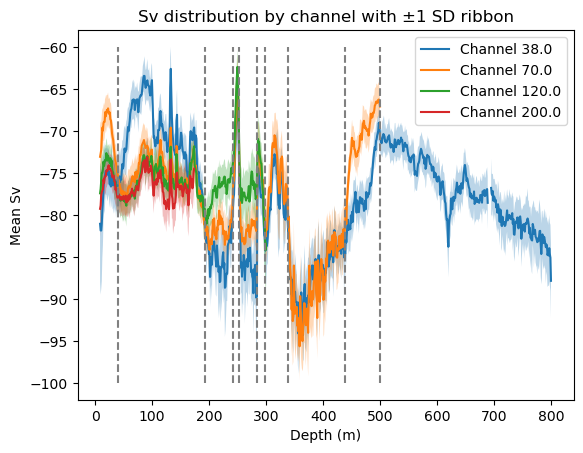

In [6]:
# Simplistic layers separation
borders = [40,
           192,
           241,
           252,
           283,
           298,
           339,
           439,
           499] # FSSL borders identified visually on echogram

# Plot each channel with ribbon
fig, ax = plt.subplots()

for channel in mean_sv.channel:
    depth = mean_sv["depth"]
    mean_vals = mean_sv.sel(channel=channel)
    std_vals = std_sv.sel(channel=channel)

    ax.plot(depth, mean_vals, label=f"Channel {channel.values}")
    ax.fill_between(
        depth,
        mean_vals - std_vals,
        mean_vals + std_vals,
        alpha=0.3
    )

ax.vlines(borders, ymin=-100, ymax=-60, linestyle='--', colors="grey")

ax.set_xlabel("Depth (m)")
ax.set_ylabel("Mean Sv")
ax.legend()
ax.set_title("Sv distribution by channel with ±1 SD ribbon")
plt.show();

In [7]:
import numpy as np
import xarray as xr

# Build full borders (include min and max of depth)
depth = sv["depth"]
time = sv["time"]
borders_full = np.concatenate([[depth.min().item()], borders, [depth.max().item()]])

# Digitize depths into layer indices
layer_idx = np.digitize(depth, borders_full) - 1  # subtract 1 for 0-based layer indices
layer_idx = np.stack([layer_idx for i in range(frame)], axis=0) # assign layer to each pixel and not 

# 3Make a new DataArray for the layer index (aligned with depth)
layer_idx_da = xr.DataArray(
    layer_idx,
    coords={"time": sv.time, "depth": sv.depth},
    dims=["time", "depth"],
    name="layer"
)

# Assign as coordinate
sv = sv.assign_coords(layer=layer_idx_da)

In [17]:
import pandas as pd

FIGSIZE = (6, 5)
REF_FREQ = 38.
N_SAMPLES = 100_000

# Get valid Sv values as xarray.DataArray and print maximum valid depth per channel
valid = ~np.isnan(sv)
valid_any = valid.any(dim=[d for d in sv.dims if d not in ("depth", "channel")])
valid_depths = sv["depth"].where(valid_any)
max_valid_depth = valid_depths.max(dim="depth", skipna=True)

# 2D hexbin plot in the 0 - 300 m depth range
max_freq = 120.
max_depth = float(max_valid_depth.sel(channel=max_freq))

sv = filter_depth(sv, max_depth)
ch_list = get_ch_list(sv, max_freq, ch_ref=REF_FREQ)
sv_diffs = compute_differences(sv, ch_ref=REF_FREQ, ch_list=ch_list)

sv_diffs_and_layer = sv_diffs.copy()
sv_diffs_and_layer["layer"] = sv["layer"]

flats = flatten_valid(*sv_diffs_and_layer.values())
samples = sample_safe(*flats, n_samples=N_SAMPLES)

df = pd.DataFrame.from_dict(dict(zip(sv_diffs_and_layer.keys(), samples)))

n_samples (100000) > array length (14526), keeping all elements...


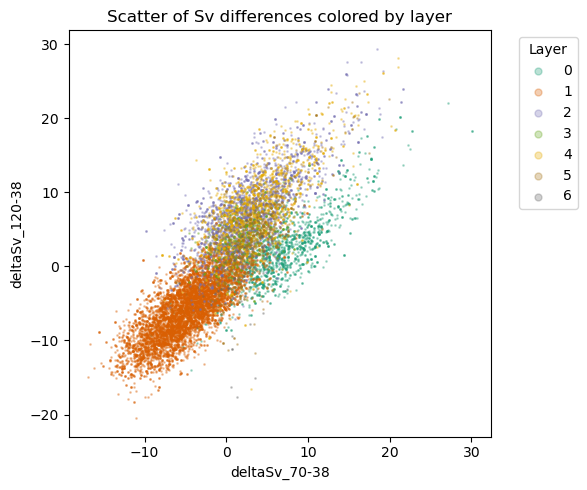

In [ ]:
df["layer"] = df["layer"].astype("category")

# Generate colors for each layer
layers = df["layer"].cat.categories
colors = plt.get_cmap("Dark2")(np.linspace(0, 1, len(layers)))
color_dict = dict(zip(layers, colors))

plt.figure(figsize=FIGSIZE)

for layer in layers:
    mask = df["layer"] == layer
    plt.scatter(
        df.loc[mask, "deltaSv_70-38"],
        df.loc[mask, "deltaSv_120-38"],
        s=1,
        alpha=0.3,
        color=color_dict[layer],
        label=str(layer)
    )

plt.xlabel("deltaSv_70-38")
plt.ylabel("deltaSv_120-38")
plt.title("Scatter of Sv differences colored by layer")
plt.legend(title="Layer", markerscale=5, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

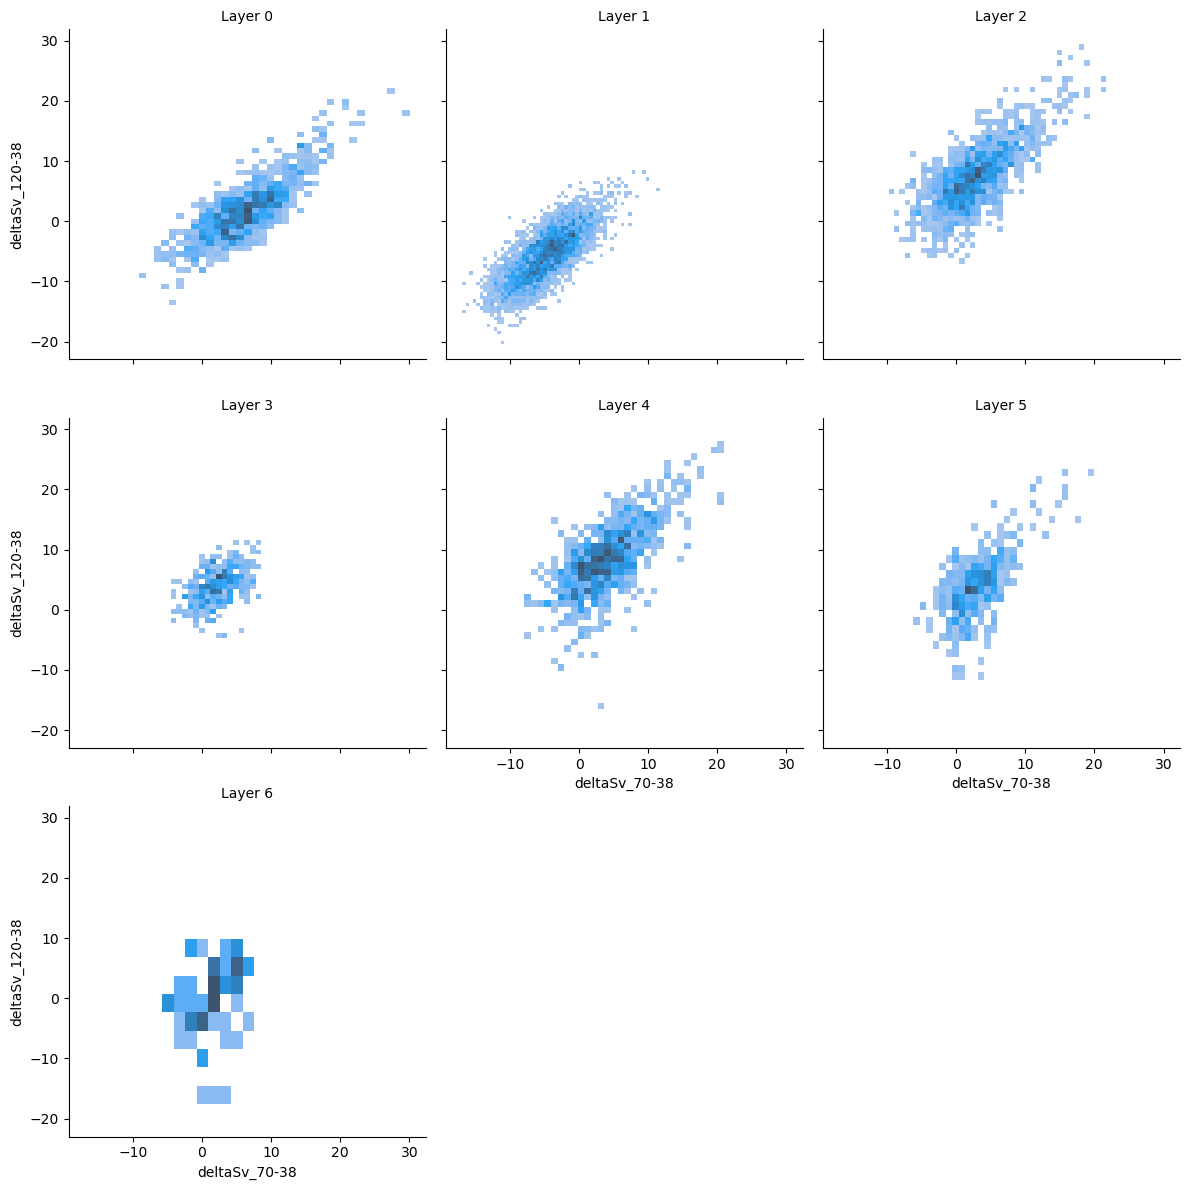

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'layer' is categorical
df["layer"] = df["layer"].astype("category")

# Create FacetGrid: one scatter plot per layer
g = sns.FacetGrid(df, col="layer", col_wrap=3, height=4, sharex=True, sharey=True)
#g.map_dataframe(sns.scatterplot, x="deltaSv_70-38", y="deltaSv_120-38", s=5, alpha=0.5)
g.map_dataframe(sns.histplot, x="deltaSv_70-38", y="deltaSv_120-38")
#g.map_dataframe(sns.kdeplot, x="deltaSv_70-38", y="deltaSv_120-38", fill=True)

# Adjust titles and layout
g.set_axis_labels("deltaSv_70-38", "deltaSv_120-38")
g.set_titles(col_template="Layer {col_name}")
plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure 'layer' is categorical
df["layer"] = df["layer"].astype("category")

# Create FacetGrid: one scatter plot per layer
sns.histplot(x="deltaSv_70-38", y="deltaSv_120-38", )

# Adjust titles and layout
g.set_axis_labels("deltaSv_70-38", "deltaSv_120-38")
g.set_titles(col_template="Layer {col_name}")
plt.tight_layout()
plt.show()

In [21]:
import numpy as np
import pandas as pd

layer_groups = df.groupby("layer")

gaussians = {}
for layer, group in layer_groups:
    X = group[["deltaSv_70-38", "deltaSv_120-38"]].values
    mu = X.mean(axis=0)
    cov = np.cov(X, rowvar=False)
    gaussians[layer] = {"mean": mu, "cov": cov}

/var/folders/mr/p37q64sn0fj06kw8cghzs3v40000gn/T/ipykernel_88117/2056365332.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  layer_groups = df.groupby("layer")


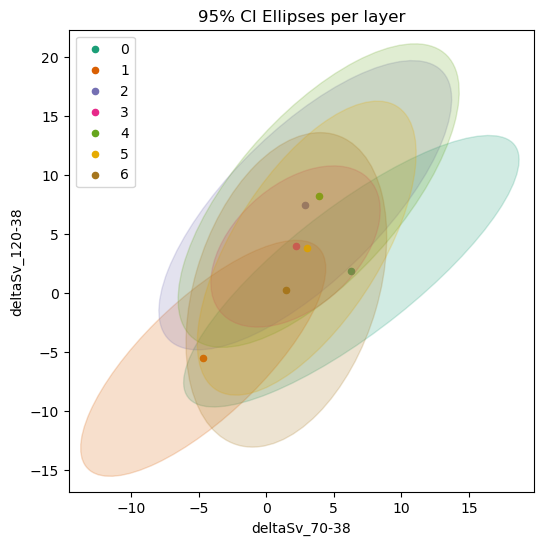

In [26]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def plot_gaussian_ellipse(ax, mean, cov, color='r', alpha=0.3, n_std=5.991):
    """
    Plot a 2D Gaussian ellipse for 95% CI.
    n_std = chi2.ppf(0.95, df=2) ~ 5.991
    """
    # Eigen decomposition
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    
    # Width and height
    width, height = 2 * np.sqrt(vals * n_std)
    angle = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                      edgecolor=color, facecolor=color, alpha=alpha)
    ax.add_patch(ellipse)

# Plot
fig, ax = plt.subplots(figsize=(6,6))

colors = plt.get_cmap("Dark2").colors
for i, (layer, params) in enumerate(gaussians.items()):
    mu, cov = params["mean"], params["cov"]
    plot_gaussian_ellipse(ax, mu, cov, color=colors[i % len(colors)], alpha=0.2)
    ax.scatter(*mu, color=colors[i % len(colors)], label=str(layer), s=20)

ax.set_xlabel("deltaSv_70-38")
ax.set_ylabel("deltaSv_120-38")
ax.set_title("95% CI Ellipses per layer")
ax.legend()
plt.show()


In [27]:
def bhattacharyya_distance(mu1, cov1, mu2, cov2):
    cov_mean = 0.5 * (cov1 + cov2)
    diff = mu2 - mu1
    term1 = 0.125 * diff.T @ np.linalg.inv(cov_mean) @ diff
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1)*np.linalg.det(cov2)))
    return term1 + term2

# Compute pairwise distances
layers = list(gaussians.keys())
for i in range(len(layers)):
    for j in range(i+1, len(layers)):
        g1, g2 = gaussians[layers[i]], gaussians[layers[j]]
        d = bhattacharyya_distance(g1["mean"], g1["cov"], g2["mean"], g2["cov"])
        print(f"Bhattacharyya distance between layer {layers[i]} and {layers[j]}: {d:.3f}")


Bhattacharyya distance between layer 0 and 1: 0.815
Bhattacharyya distance between layer 0 and 2: 0.991
Bhattacharyya distance between layer 0 and 3: 0.709
Bhattacharyya distance between layer 0 and 4: 0.863
Bhattacharyya distance between layer 0 and 5: 0.403
Bhattacharyya distance between layer 0 and 6: 0.355
Bhattacharyya distance between layer 1 and 2: 1.050
Bhattacharyya distance between layer 1 and 3: 1.000
Bhattacharyya distance between layer 1 and 4: 1.111
Bhattacharyya distance between layer 1 and 5: 0.700
Bhattacharyya distance between layer 1 and 6: 0.540
Bhattacharyya distance between layer 2 and 3: 0.235
Bhattacharyya distance between layer 2 and 4: 0.010
Bhattacharyya distance between layer 2 and 5: 0.158
Bhattacharyya distance between layer 2 and 6: 0.341
Bhattacharyya distance between layer 3 and 4: 0.257
Bhattacharyya distance between layer 3 and 5: 0.105
Bhattacharyya distance between layer 3 and 6: 0.219
Bhattacharyya distance between layer 4 and 5: 0.136
Bhattacharyy